# IDV-Python Practice: MSE diagram for sounding data 
<div> 
<img src="https://www.earthcube.org/sites/default/files/doc-repository/logo_earthcube_cube-only_SMALL.png", width=120, height=100, style="float:right">
</div> 
### Author: Wei-Ming Tsai 
### Jun, 2018 

In [1]:
import os
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import csv

# check current directory
os.chdir('/Users/willytsai/Working-Space/Sounding_profile')
os.getcwd()

'/Users/willytsai/Working-Space/Sounding_profile'

In [2]:
# read csv data from the current directory
Filename="sounding_91765.csv"

with open(Filename) as f:
    reader = csv.reader(f)
    next(reader) # skip header
    next(reader) # skip header
    data = [r for r in reader]
    data=np.asarray(data,dtype=np.float64) # convert list to float array 


In [3]:
# Recorded Paramters 
pressure=np.flip(data[:,0],0) # pressure [hpa]
Altitude=np.flip(data[:,1],0) # altitude [m]
Temp=np.flip(data[:,2],0)     # insitu air temperature [C]
Temp_dew=np.flip(data[:,3],0) # dew point temperature [C]

### (a) Vertical profiles of Temp and Temp_dew

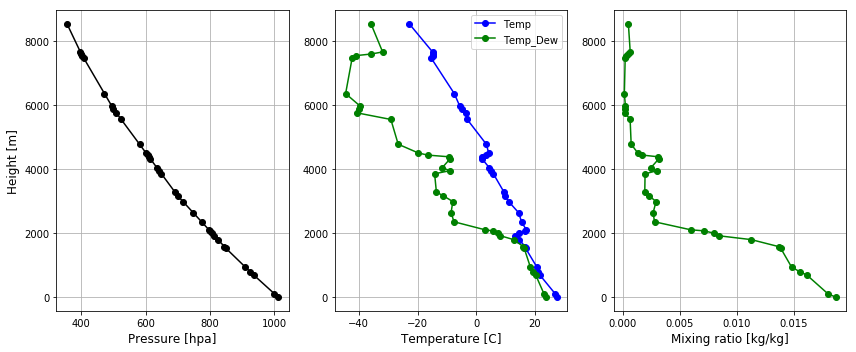

In [4]:
# Frist glimpse of data
plt.figure(figsize=[12,5])
plt.subplot(1,3,1)
plt.plot(pressure[:35],Altitude[:35],'-ok')
plt.ylabel('Height [m]',fontsize=12);plt.xlabel('Pressure [hpa]',fontsize=12)
plt.grid()

plt.subplot(1,3,2)
plt.plot(Temp[:35],Altitude[:35],'-ob')
plt.plot(Temp_dew[:35],Altitude[:35],'-og')
plt.xlabel('Temperature [C]',fontsize=12)
plt.legend(['Temp','Temp_Dew'],loc=1)
plt.grid()

# CC-equation for specific humidity retrival
es=6.1094*np.exp(17.625*Temp_dew/(Temp_dew+243.04))
q=0.622*es/(pressure-es)

plt.subplot(1,3,3)
plt.plot(q[:35],Altitude[:35],'-og')
plt.xlabel('Mixing ratio [kg/kg]',fontsize=12)
plt.grid()

plt.tight_layout()
plt.show()

### (b) Construct Moist Static Energy (MSE) diagram 

In [5]:
# Parameters
Cp=1004; # J/(kg K)
Lv=(2500.8-2.36*Temp+0.0016*Temp**2-0.00006*Temp**3)*1000; # latent heat J/kg
Rd=287.15 # J/kg

# (a). Calculate equivalent potential temperature (theta_e) and saturated theta_e
theta_e=(Temp+273.15+Lv*q/Cp)*(1000/pressure)**(Rd/Cp);
es=6.1094*np.exp(17.625*Temp/(Temp+243.04));
qs=0.622*es/(pressure-es)
theta_es=(Temp+273.15+Lv*qs/Cp)*(1000/pressure)**(Rd/Cp);
# dry air: theta_e-->theta
theta=(Temp+273.15)*(1000/pressure)**(Rd/Cp);

# (b). static energy 
dse=(Cp*(Temp+273.15)+9.8*Altitude)/1000 # dry static energy [KJ/kg]
mse=(Cp*(Temp+273.15)+9.8*Altitude+Lv*q)/1000; # moist static energy [KJ/kg]
mse_s=(Cp*(Temp+273.15)+9.8*Altitude+Lv*qs)/1000; # moist static energy [KJ/kg]

In [49]:
# (c). Column water vapor (CWV)
cwv=np.trapz(q,Altitude);print cwv
# LCL
#LCL=960.1; #[hpa] calculated by IDV

idx=np.abs(pressure-1000).argmin(); # define parcel at 1000 hpa 
for x in range(20):
    Tp=Temp[idx];Tpd=Tp-9.8/Cp*Altitude[idx+x]
    esp=6.1094*np.exp(17.625*Tpd/(Tpd+243.04));
    qsp=0.622*esp/(pressure[x]-esp)   
    if qsp-q[idx] < 0:
        LCL=np.interp(q[idx],[qsp,tmp],[pressure[idx+x],pressure[idx+k]]);
        break
    tmp=qsp;k=x
    
# CAPE 
CAPE=630; # [J/kg]




39.3240463038


### Summarized MSE diagram 

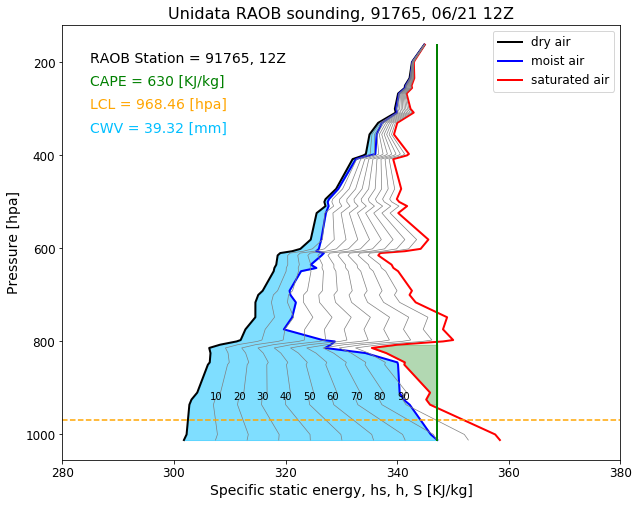

In [53]:
# MSE vertical profiles
h=plt.figure(figsize=[10,8])
plt.plot(dse[:45],pressure[:45],'-k',linewidth=2)
plt.plot(mse[:45],pressure[:45],'-b',linewidth=2)
plt.plot(mse_s[:45],pressure[:45],'-r',linewidth=2)

# different Relative humidity 
qr=np.zeros((9,np.size(qs))); mse_r=qr# container
for i in range(9):
    qr[i,:]=qs*0.1*(i+1);
    mse_r[i,:]=(Cp*(Temp+273.15)+9.8*Altitude+Lv*qr[i,:])/1000;

for i in range(9):
    plt.plot(mse_r[i,:45],pressure[:45],'-',color='grey',linewidth=0.7)
    plt.text(mse_r[i,3]-1,pressure[3],str((i+1)*10))

# drawing LCL
line_lcl=np.squeeze(np.ones((1,300))*LCL);
plt.plot(np.linspace(280,400,300),line_lcl,'--',color='orange')
# air parcel arising from 1000 hpa    
mse_p=np.squeeze(np.ones((1,np.size(theta)))*mse[0]);

# illustration of CAPE
plt.plot(mse_p[:45],pressure[:45],color='green',linewidth=2)
dd=mse_p-mse_s;
idx=np.abs(pressure-LCL).argmin()
for i in range(np.size(mse)):
     if dd[i] > 0 and dd[i+1] <0:
            idx2=i+1;break
plt.fill_betweenx(pressure[idx+1:idx2],mse_p[idx+1:idx2],mse_s[idx+1:idx2],interpolate=True
                    ,color='green',alpha='0.3');

plt.fill_betweenx(pressure[:45],dse[:45],mse[:45],color='deepskyblue',alpha='0.5')
plt.gca().invert_yaxis() # reverse y-axis for pressure coordinate
plt.xlim([280,380])
plt.xlabel('Specific static energy, hs, h, S [KJ/kg]',fontsize=14)
plt.ylabel('Pressure [hpa]',fontsize=14)
plt.xticks(fontsize=12);plt.yticks(fontsize=12)
plt.title('Unidata RAOB sounding, 91765, 06/21 12Z',fontsize=16)

# Text parts
plt.text(285,200,'RAOB Station = '+ Filename[9:14] +', 12Z',fontsize=14);
plt.text(285,250,'CAPE = '+str(CAPE)+' [KJ/kg]',fontsize=14,color='green');
plt.text(285,300,'LCL = '+str(np.around(LCL,decimals=2))+' [hpa]',fontsize=14,color='orange');
plt.text(285,350,'CWV = '+str(np.around(cwv,decimals=2))+' [mm]',fontsize=14,color='deepskyblue');
plt.legend(['dry air','moist air','saturated air'],fontsize=12);


plt.show()